# **Finetuning a large language model**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sekhansen/text_algorithms_econ/blob/main/notebooks/6_llm_finetuning.ipynb)

# 0. Setup

In [1]:
# Instructions for Colab: 
# 1. First CHANGE RUNTIME TYPE to GPU 
# 2. Run install commands
# 3. You might need to RESTART RUNTIME
# 4. Run the rest of the cells below

In [1]:
%%capture

# install required libraries
!pip3 install transformers                  # HuggingFace library for interacting with BERT (and multiple other models)
!pip3 install datasets                      # HuggingFace library to process dataframes
!pip3 install sentence-transformers         # library to use Sentence Similarity BERT
!pip3 install bertviz                       # visualize BERT's attention weigths
!pip3 install annoy                         # Spotify's library for finding nearest neighbours                     
!pip3 install ipywidgets

In [3]:
# (COLAB) you might need to restart RUNTIME after installing packages!

In [4]:
# import libraries
import gdown
import pandas as pd
import numpy as np
import gdown
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from transformers import AutoModel, BertModel, AutoTokenizer, AutoModelForSequenceClassification, pipeline, TrainingArguments, Trainer, utils
from transformers.pipelines.base import KeyDataset
from datasets import load_dataset, load_metric, Dataset, DatasetDict

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

from google.colab import output
output.enable_custom_widget_manager()

# test GPU
print(f"GPU: {torch.cuda.is_available()}")

GPU: True


In [5]:
# define dictionary with paths to data in Google Drive
urls_dict = {"10k_sent_2019_firms":        ("https://drive.google.com/uc?id=1eQB8rwSklyVD3u8sZImFII74b7jBeUIL", "parquet"),
            }

In [6]:
# download all files
for file_name, attributes in urls_dict.items():
    url = attributes[0]
    extension = attributes[1]
    gdown.download(url, f"./{file_name}.{extension}", quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1eQB8rwSklyVD3u8sZImFII74b7jBeUIL
To: /content/10k_sent_2019_firms.parquet
100%|██████████| 720k/720k [00:00<00:00, 82.0MB/s]


# 1. Load and prepare the data

This tutorial uses text data from the **10-K reports** filed by publicly-traded firms in the U.S. in 2019. 10-K reports are a very rich source of data since firms include information regarding their organizational structure, financial performance and risk factors. We will use a version of the data where the risk factors section of each report has been splitted into sentences and each sentence has been assigned an ID that combines the firm identifier (i.e. **CIK**) and a sentence number. The raw data we use has a total of 1,744,131 sentences for 4,033 firms.

More on the 10-K reports [here](https://www.investor.gov/introduction-investing/getting-started/researching-investments/how-read-10-k).

In [7]:
# read data
df = pd.read_parquet("10k_sent_2019_firms.parquet")
df

,sentences,cik,year,sent_no,sent_id,naics2,naics2_name,sentence_len,keep_sent
0,The following discussion sets forth the materi...,19617,2019,0,19617_0,52,Finance and Insurance,18,True
1,Readers should not consider any descriptions o...,19617,2019,1,19617_1,52,Finance and Insurance,23,True
2,Any of the risk factors discussed below could ...,19617,2019,2,19617_2,52,Finance and Insurance,53,True
3,JPMorgan Chase's businesses are highly regulat...,19617,2019,4,19617_4,52,Finance and Insurance,25,True
4,JPMorgan Chase is a financial services firm wi...,19617,2019,5,19617_5,52,Finance and Insurance,10,True
...,...,...,...,...,...,...,...,...,...
6793,"With the completion of the TFCF acquisition, o...",1744489,2019,194,1744489_194,51,Information,19,True
6794,The increased indebtedness could have the effe...,1744489,2019,195,1744489_195,51,Information,22,True
6795,The increased levels of indebtedness could als...,1744489,2019,196,1744489_196,51,Information,14,True
6796,"repurchases and dividends, and other activitie...",1744489,2019,197,1744489_197,51,Information,21,True


# 2. Load model and tokenizer




In [8]:
# load a tokenizer using the name of the model we want to use
sec_tokenizer = AutoTokenizer.from_pretrained("nlpaueb/sec-bert-base")

# inspect the configuration of the tokenizer
sec_tokenizer

BertTokenizerFast(name_or_path='nlpaueb/sec-bert-base', vocab_size=30000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [9]:
# load the model trained on 10-K report using its name
sec_model = AutoModel.from_pretrained("nlpaueb/sec-bert-base")

# put model in evaluation model (we will not do any training)
sec_model = sec_model.eval()

Some weights of the model checkpoint at nlpaueb/sec-bert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 3. Finetuning a model

We will show how we can finetune a BERT model for any classification task we want. Finetuning involves training (with a very small learning rate) all of the parameters of the model for a particular task. This is one of the most powerful ways of using modern language models.

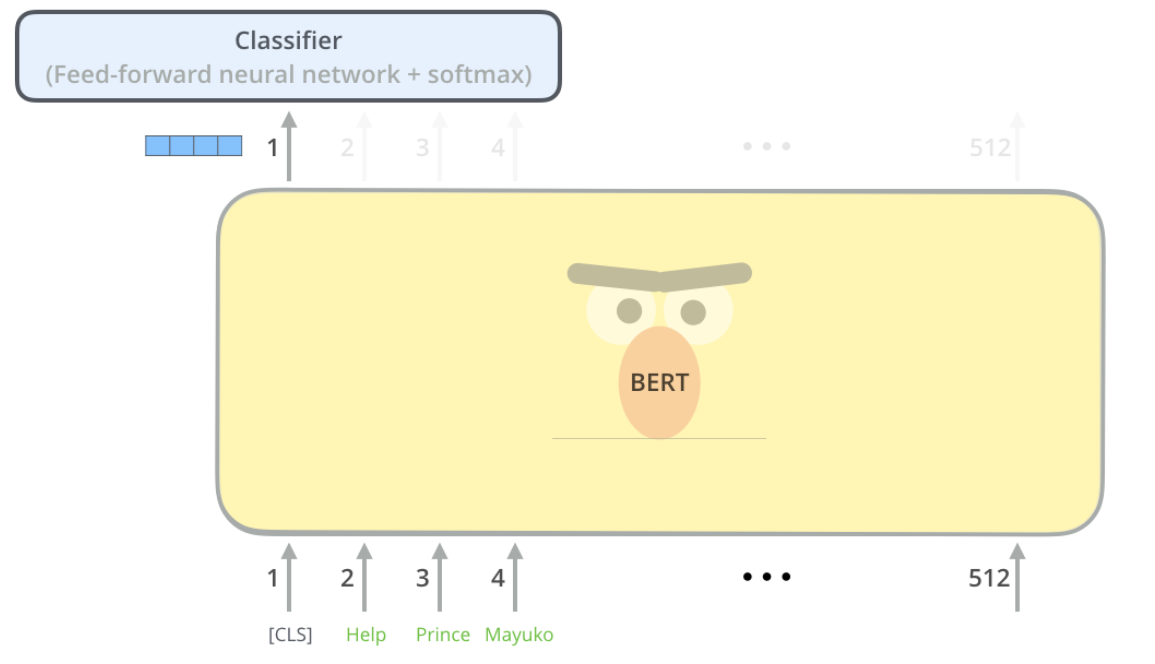

*Source: Alammar (2018)*

In [10]:
# get only the NAICS2 code for each sentence to use as the labels for our regression
labels = df[["naics2"]]

In [11]:
# create list with all the indexes of available sentences
sent_idxs = list(range(0, len(labels)))
len(sent_idxs)

6798

In [12]:
# perform a train/test split
train_idxs, test_idxs = train_test_split(sent_idxs, test_size=0.2, random_state=92)
print(f" Train sentences: {len(train_idxs)}\n", f"Test sentences: {len(test_idxs)}")

 Train sentences: 5438
 Test sentences: 1360


In [13]:
# format the train data adequately
df_finetune = df.loc[train_idxs].copy()

df_finetune = df_finetune[["sentences", "naics2"]]
df_finetune.columns = ["sentences", "label"]

# transform labels into integers
df_finetune["label"] = df_finetune["label"].astype(int)
df_finetune

# map labels from original sector code to ints from 0 to num_sectors
num_sectors = len(df_finetune.groupby('label').size())
label2id_label = {k:v for k,v in zip(df_finetune.groupby('label').size().index.values, range(0, num_sectors))}
df_finetune["label"] = df_finetune["label"].apply(lambda x: label2id_label[x])
df_finetune

,sentences,label
3639,We experienced a work stoppage in 2008 when a ...,0
2680,"Finally, holders of the Tesla Convertible Note...",0
1507,There can be significant differences between o...,3
911,We also rely on other companies to maintain re...,2
621,The techniques used for attacks by third parti...,0
...,...,...
5007,Our revenues and cash requirements are affecte...,1
710,"As is common in our industry, our advertisers ...",2
6162,Global markets for the Company's products and ...,0
4138,"Longer payment cycles in some countries, incre...",2


In [14]:
# format the test data adequately
df_test = df.loc[test_idxs].copy()

df_test = df_test[["sentences", "naics2"]]
df_test.columns = ["sentences", "label"]

# transform labels into integers
df_test["label"] = df_test["label"].astype(int)
df_test

# map labels from original sector code to ints from 0 to num_sectors
df_test["label"] = df_test["label"].apply(lambda x: label2id_label[x])
df_test

,sentences,label
1236,• integration of the acquired company's accou...,2
474,Competition for qualified personnel within the...,3
3418,Any reduction in our and our subsidiaries' cre...,3
6564,Natural disasters or other catastrophes could ...,1
2646,For the battery and drive unit on our current ...,0
...,...,...
1950,Regulatory requirements in the U.S. and in non...,3
6648,If personal information of our customers or em...,2
6529,The evolution of retailing in online and mobil...,1
6452,"Our success depends, in part, on our ability t...",1


In [15]:
# transform data into Dataset class
finetune_dataset = Dataset.from_pandas(df_finetune)
test_dataset = Dataset.from_pandas(df_test)

In [16]:
# tokenize the dataset
def tokenize_function(examples):
    return sec_tokenizer(examples["sentences"], max_length=60, padding="max_length", truncation=True)

tokenized_ft = finetune_dataset.map(tokenize_function, batched=True)    # batched=True is key for training
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_ft

Map:   0%|          | 0/5438 [00:00<?, ? examples/s]

Map:   0%|          | 0/1360 [00:00<?, ? examples/s]

Dataset({
    features: ['sentences', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5438
})

In [25]:
# load the model for finetunning. 
# NOTE that we use a different class from the transformers library:
# AutoModel vs. AutoModelForSequenceClassification
num_labels = len(df_finetune.groupby('label').size())
model_ft = AutoModelForSequenceClassification.from_pretrained("nlpaueb/sec-bert-base", 
                                                              num_labels=num_labels,
                                                              output_hidden_states=False)

Some weights of the model checkpoint at nlpaueb/sec-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

You can find a complete description of all the available parameters of the ```TrainingArguments()``` class [here](https://huggingface.co/docs/transformers/v4.21.2/en/main_classes/trainer#transformers.TrainingArguments).

In [26]:
# define the main arguments for training
training_args = TrainingArguments("./",                               # path to save model
                                  learning_rate=3e-5,                 # we use a very small learning rate
                                  num_train_epochs=5,                 # number of iterations through the corpus
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=1,
                                  evaluation_strategy="no",
                                  save_strategy="no")

In [27]:
# define the set of metrics to be computed through the training process
def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")
    metric4 = load_metric("accuracy")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    precision = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    recall = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    f1 = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]
    
    return {"precision": precision, "recall": recall, 
            "f1": f1, "accuracy": accuracy}

# by default the Trainer will use MSEloss from (torch.nn) for regression and
# CrossEntropy loss for classification
trainer = Trainer(
    model=model_ft,
    args=training_args,
    train_dataset=tokenized_ft,
    eval_dataset=tokenized_ft,  # in-sample evaluation
    compute_metrics=compute_metrics
)

In [28]:
# train model (should take around 5 minutes with GPU)
trainer.train()

# save final version of the model
#trainer.save_model("./models/")

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.831300
1000,0.524400
1500,0.376100
2000,0.246800
2500,0.133800
3000,0.077700


TrainOutput(global_step=3400, training_loss=0.32789999905754535, metrics={'train_runtime': 380.6943, 'train_samples_per_second': 71.422, 'train_steps_per_second': 8.931, 'total_flos': 838373210251200.0, 'train_loss': 0.32789999905754535, 'epoch': 5.0})

In [29]:
# evaluate final model on the test dataset
results = trainer.predict(tokenized_test)
final_metrics = results[2]
print(final_metrics)

{'test_loss': 1.2546815872192383, 'test_precision': 0.7941176470588235, 'test_recall': 0.7941176470588235, 'test_f1': 0.7941176470588235, 'test_accuracy': 0.7941176470588235, 'test_runtime': 18.7918, 'test_samples_per_second': 72.372, 'test_steps_per_second': 72.372}


In [30]:
# compare finetuning to other methods
df_compare = pd.DataFrame({"accuracy": [0.616176, 0.627206, 0.708088, final_metrics["test_accuracy"]],
                           "model": ["word_embeddings", "BERT", "SEC BERT", "Finetuned BERT"]})
df_compare

,accuracy,model
0,0.616176,word_embeddings
1,0.627206,BERT
2,0.708088,SEC BERT
3,0.794118,Finetuned BERT


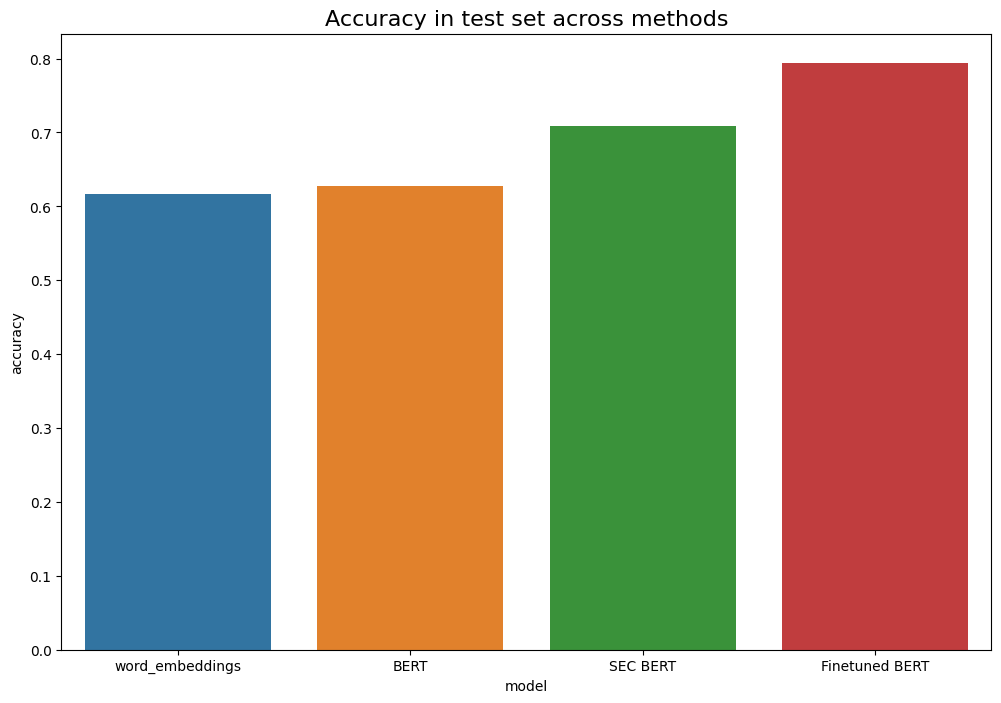

In [31]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_compare, x="model", y="accuracy")
plt.title("Accuracy in test set across methods", fontsize=16)
plt.show()